# Programming Assignment 3 - Hierarchical Reinforcement Learning

## Imports

In [404]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import softmax
from tqdm.autonotebook import tqdm
import seaborn as sns

## Environment Setup

In [405]:
GAMMA   = 0.99      # Discount factor

In [406]:
class TaxiEnv:

    def __init__(self):
        self._env           = gym.make("Taxi-v3", render_mode="ansi")
        self.dest_locs      = self._env.unwrapped.locs
        self.num_states     = self._env.observation_space.n
        self.num_actions    = self._env.action_space.n

    def decode_state(self, state):
        taxi_row, taxi_col, pass_index, dest_index = self._env.unwrapped.decode(state)
        return (taxi_row, taxi_col, pass_index, dest_index)
    
    def taxi_loc(self, state, grid_size=5):
        taxi_row, taxi_col, _, _ = self.decode_state(state)
        return taxi_row * grid_size + taxi_col

    def reset(self, seed=0):
        self.state, self.info = self._env.reset(seed=seed)
        return self.state, self.info
    
    def step(self, action):
        ret = self._env.step(action)
        self.state, self.info = ret[0], ret[-1]
        return ret
    
    def render(self):
        print(self._env.render())

Action Mapping:
* 0 - Move taxi South
* 1 - Move taxi North
* 2 - Move taxi East
* 3 - Move taxi West
* 4 - Pick up passenger
* 5 - Drop off passenger

Passenger Location Mapping:
* 0 - Red
* 1 - Green
* 2 - Yellow
* 3 - Blue
* 4 - In Taxi

Destination Mapping:
* 0 - Red
* 1 - Green
* 2 - Yellow
* 3 - Blue

In [407]:
env = TaxiEnv()
env.reset(0)
env.step(1)
env.render()

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)



In [408]:
env.dest_locs

[(0, 0), (0, 4), (4, 0), (4, 3)]

## Action Selection Policies

In [409]:
seed = 42
np.random.seed(seed)

In [410]:
# Epsilon greedy
def epsgreedy_policy(num_actions, Q, state, epsilon):
    if np.random.random() < epsilon: 
        return np.random.randint(num_actions) 
    else:
        return Q[state].argmax()
    
# Softmax
def softmax_policy(num_actions, Q, state, tau):
    x = [Q[state, action] / tau for action in range(num_actions)]
    return np.random.choice(num_actions, p=softmax(x)) 

## Plotting Functions

In [411]:
# Return vs episodes curve with std bands
def return_vs_episodes(allrewards, title, print_mean=False):
    allrewards = np.array(allrewards)

    chunksize = allrewards.shape[-1] // 1000
    chunk_rewards = np.empty((allrewards.shape[0], int(np.ceil(allrewards.shape[1] / chunksize))))

    for i in range(chunk_rewards.shape[-1]-1):
        chunk_rewards[:, i] = allrewards[:, chunksize*i: chunksize*(i+1)-1].mean(axis=-1)
    chunk_rewards[:, chunk_rewards.shape[-1]-1] = allrewards[:, chunksize*(chunk_rewards.shape[-1]-1): ].mean(axis=-1)

    meanreward = np.mean(chunk_rewards, axis=0)
    stdreward = np.std(chunk_rewards, axis=0)
    
    if print_mean:
        print(f"Final 100-step mean reward = {allrewards[:, -100:].mean()}")
    
    plt.figure(figsize=(8, 5))
    plt.plot(meanreward)
    plt.fill_between(range(len(meanreward)), meanreward - stdreward, meanreward + stdreward, alpha=0.5)
    plt.xlabel('Episode')
    plt.ylabel('Return')
    plt.xticks(range(0,chunk_rewards.shape[-1]+1, int(np.floor(chunk_rewards.shape[-1] / 5))), 
               labels=range(0, allrewards.shape[-1]+1, int(np.floor(allrewards.shape[-1] / 5))))
    plt.title(title)
    plt.savefig(title+'.png', dpi=450)
    plt.show()

In [412]:
def plot_Q(Q, dest, title):
    plt.figure(figsize=(7, 6))
    plt.title(title)

    num_rows = 5  # Number of rows in the Taxi grid
    num_cols = 5  # Number of columns in the Taxi grid

    max_Q = np.max(Q, axis=-1).reshape((num_rows, num_cols))

    plt.pcolor(max_Q, edgecolors='k', linewidths=2, cmap='viridis')
    plt.colorbar()

    policy = np.argmax(Q, axis=-1).reshape((num_rows, num_cols))
    
    # Define action map and drawing quivers
    action_map = {
        0: (0, 1),   # SOUTH
        1: (0, -1),  # NORTH
        2: (1, 0),   # EAST
        3: (-1, 0)   # WEST
    }

    u = np.zeros_like(max_Q, dtype=float)
    v = np.zeros_like(max_Q, dtype=float)
    for row in range(num_rows):
        for col in range(num_cols):
            action = policy[row, col]
            u[row, col], v[row, col] = action_map[action]

    X, Y = np.meshgrid(np.arange(num_cols) + 0.5, np.arange(num_rows) + 0.5)
    dr, dc = dest
    dr = dr
    quiver_mask = np.ones_like(max_Q, dtype=bool)
    quiver_mask[dr, dc] = False
    plt.quiver(X[quiver_mask], Y[quiver_mask], u[quiver_mask], v[quiver_mask], color='white', scale=3.0, scale_units='xy', angles='xy', width=0.005)

    # Destination marker
    dest_names = {
        (4, 0): 'Y',
        (4, 3): 'B',
        (0, 0): 'R',
        (0, 4): 'G',
        (2,0): 'A1',
        (2,3):'A2'
    }
    plt.text(dc + 0.5, dr + 0.5, dest_names[(dr, dc)], color='red', ha='center', va='center', fontweight='bold', fontsize=15)

    # Draw walls
    # Vertical walls
    plt.plot([2 ,2], [0, 2], color='black', linewidth=8)
    plt.plot([3, 3], [3 ,5], color='black', linewidth=8)
    plt.plot([1, 1], [3, 5], color='black', linewidth=8)

    plt.gca().invert_yaxis()
    plt.xticks(np.arange(num_cols), np.arange(num_cols))
    plt.yticks(np.arange(num_rows), np.arange(num_rows))
    plt.xlim([0, num_cols])
    plt.ylim([num_rows,0])
    plt.savefig(title+'.png', dpi=450)
    plt.show()
    
def plot_Policy(plotting_arr):
    num_rows = 5  
    num_cols = 5  

    action_map = {
        0: (0, 1),   
        1: (0, -1),  
        2: (1, 0),   
        3: (-1, 0)   
    }

    for identifier, path in plotting_arr.items():
        if len(path["trajectory"]) == 0:
            continue
        pass_loc, pass_dest = identifier
        Q = np.zeros((num_rows,num_cols))
        u = np.zeros_like(Q, dtype=float)
        v = np.zeros_like(Q, dtype=float)
        u_prime = np.zeros_like(Q, dtype=float)
        v_prime = np.zeros_like(Q, dtype=float)
        
        for i in path["trajectory"]:
            state, action, option = i
            taxi_row, taxi_col, pass_index, dest_index = env.decode_state(state)
            if pass_index != 4:
                # ignore pickup and drop action
                if action in action_map:
                    u[taxi_row, taxi_col], v[taxi_row, taxi_col] = action_map[action]
            else:
                # ignore pickup and drop action
                if action in action_map:
                    u_prime[taxi_row, taxi_col], v_prime[taxi_row, taxi_col] = action_map[action]
            

        X, Y = np.meshgrid(np.arange(num_cols) + 0.5, np.arange(num_rows) + 0.5)
        quiver_mask = np.ones_like(Q, dtype=bool)
        quiver_mask[pass_dest[0], pass_dest[1]] = False
        plt.quiver(X[quiver_mask], Y[quiver_mask], u_prime[quiver_mask], v_prime[quiver_mask], color='green', scale=3.0, scale_units='xy', angles='xy', width=0.005)
        quiver_mask[pass_loc[0], pass_loc[1]] = False
        plt.quiver(X[quiver_mask], Y[quiver_mask], u[quiver_mask], v[quiver_mask], color='red', scale=3.0, scale_units='xy', angles='xy', width=0.005)
        

        dest_names = {
            (4, 0): 'Y',
            (4, 3): 'B',
            (0, 0): 'R',
            (0, 4): 'G',
            (2,0): 'A1',
            (2,3):'A2'
        }
        plt.text(pass_loc[1] + 0.5, pass_loc[0] + 0.8, f"Pickup: {dest_names[(pass_loc[0], pass_loc[1])]}", color='red', ha='center', va='center', fontweight='bold', fontsize=8)
        plt.text(pass_dest[1] + 0.5, pass_dest[0] + 0.8, f"Dest: {dest_names[(pass_dest[0], pass_dest[1])]}", color='green', ha='center', va='center', fontweight='bold', fontsize=8)
        taxi_init_row, taxi_init_col = env.decode_state(path["trajectory"][0][0])[:2]
        plt.text(taxi_init_col + 0.5, taxi_init_row + 0.9, "start", color='blue', ha='center', va='center', fontweight='bold', fontsize=8)
        for i in path["trajectory"]:
            state, action, option = i
            if not option:
                continue
            taxi_row, taxi_col, pass_index, dest_index = env.decode_state(state)
            if pass_index != 4:
                plt.text(taxi_col + 0.3, taxi_row + 0.15, f"O:{option}", color='red', ha='center', va='center', fontweight='bold', fontsize=6)
            else:
                plt.text(taxi_col + 0.8, taxi_row + 0.15, f"O:{option}", color='green', ha='center', va='center', fontweight='bold', fontsize=6)
        plt.plot([2 ,2], [0, 2], color='black', linewidth=8)
        plt.plot([3, 3], [3 ,5], color='black', linewidth=8)
        plt.plot([1, 1], [3, 5], color='black', linewidth=8)

        plt.xticks(np.arange(num_cols), np.arange(num_cols))
        plt.yticks(np.arange(num_rows), np.arange(num_rows))
        plt.grid(True, which='both', linestyle='-', color='black', linewidth=2)
        plt.xlim([0, num_cols])
        plt.ylim([num_rows,0])
        plt.show()
        

def eval_policy(env, Q, OPT_LIST, policy=epsgreedy_policy, param=0, offset=0):
    plotting_arr = { (pass_loc,pass_dest):{"filled": False, "trajectory":[]} for pass_loc in env.dest_locs for pass_dest in env.dest_locs }
    for i in range(10):
        done, trunc = False, False
        state, _ = env.reset(i+offset*10000)
        taxi_row, taxi_col, pass_index, dest_index = env.decode_state(state)
        pass_location = env.dest_locs[pass_index]
        dest_location = env.dest_locs[dest_index]
        identifier = None
        if (pass_index == 4 and (taxi_row,taxi_col) != dest_location) or (pass_index != 4 and (taxi_row,taxi_col) != pass_location):
            identifier = (pass_location,dest_location)
    
        while not done and not trunc:
            action = policy(env.num_actions+len(OPT_LIST), Q, state, param)
            if action < env.num_actions:
                if identifier and not plotting_arr[identifier]["filled"]:
                    plotting_arr[identifier]["trajectory"].append((state,action,None))
                next_state, reward, done, trunc, _  = env.step(action)
                state = next_state
            elif action < env.num_actions + len(OPT_LIST):
                id = action - env.num_actions
                opt = OPT_LIST[id]
                optdest = opt.dest
                if env.decode_state(state)[:2] == optdest:
                    continue    # option cannot be chosen from its termination state
                optdone = False
                i=0
                while not optdone and not trunc:
                    optact = opt.act(env.state)
                    prev_state = env.state
                    next_state, reward, done, trunc, _ = env.step(optact)
                    isOptEnd = env.decode_state(next_state)[:2] == optdest
                    if isOptEnd:
                        optdone = True
                    if identifier and not plotting_arr[identifier]["filled"]:
                        label = action-env.num_actions + 1
                        if i == 0:
                            label = f"{action-env.num_actions + 1}-Start"
                        if  optdone:
                            label = f"{action-env.num_actions + 1}-End"
                        plotting_arr[identifier]["trajectory"].append((prev_state,optact,label))
                    i+=1
                state = next_state              
            else:
                raise Exception("Undefined Action")
        if identifier:
            plotting_arr[identifier]["filled"] = True
    plot_Policy(plotting_arr)
    

## Options

In [413]:
class NavOption:

    def __init__(self, env: TaxiEnv, dest, policy, start, end, decay=0.99, alpha=0.1):
        self.env    = env
        self.Q      = np.zeros((25, env.num_actions-2), dtype=float)

        self.dest   = dest      # target destination for option
        self.policy = policy    # action selection policy function
        self.param  = start     # value of parameter for policy
        self.end    = end       # cutoff value for decaying param
        self.decay  = decay     # decay term for parameter decay
        self.alpha  = alpha     # learning rate for Q-learning

    # Returns primitive action to be executed
    def act(self, state):
        state = self.env.taxi_loc(state)
        action = self.policy(self.Q.shape[1], self.Q, state, self.param)
        return action
    
    # Performs Q-learning update
    def update(self, state, action, reward, next_state):
        state = self.env.taxi_loc(state)
        next_state = self.env.taxi_loc(next_state)
        self.Q[state, action] += self.alpha * (reward 
                                               + self.Q[next_state].max()
                                               - self.Q[state, action])
        self.param = max(self.end, self.decay * self.param)

In [414]:
policy      = epsgreedy_policy
start       = 0.2
end         = 0.01
decay       = 0.999
alpha       = 0.1

OPT_LIST = [NavOption(env, dest, policy, start, end, decay, alpha) for dest in env.dest_locs]
ctr = 0

In [415]:
Q = np.empty((env.num_states, env.num_actions+len(OPT_LIST)), dtype=float)

## SMDP Q-Learning

### Algorithm

In [416]:
def smdp(env: TaxiEnv, Q, OPT_LIST, episodes=100000, alpha=0.1, policy=softmax_policy, param=1.0, offset=0):
    option_rewards = [[] for _ in range(len(OPT_LIST))]
    episode_rewards = []
    
    for i in tqdm(range(episodes), leave=False):
        done, trunc = False, False
        episode_reward = 0
        state, _ = env.reset(i + episodes*offset)
        while not done and not trunc:
            action = policy(env.num_actions+len(OPT_LIST), Q, state, param)
            
            if action < env.num_actions:
                next_state, reward, done, trunc, _  = env.step(action)
                episode_reward+=reward
                Q[state, action] += alpha * (reward 
                                             + GAMMA*Q[next_state].max()
                                             - Q[state, action])
                
                state = next_state
                
            elif action < env.num_actions + len(OPT_LIST):
                id = action - env.num_actions
                opt = OPT_LIST[id]
                optdest = opt.dest
                if env.decode_state(state)[:2] == optdest:
                    continue    # option cannot be chosen from its termination state

                rewards = []
                optdone = False
                
                while not optdone and not trunc:
                    optact = opt.act(env.state)
                    prev_state = env.state
                    next_state, reward, done, trunc, _ = env.step(optact)
                    episode_reward+=reward
                    opt.update(prev_state, optact, reward, next_state)
                    rewards.append(reward)

                    if env.decode_state(next_state)[:2] == optdest:
                        optdone = True

                netreward = 0
                for reward in rewards[::-1]:
                    netreward = reward + GAMMA*netreward

                Q[state, action] += alpha * (netreward
                                             + GAMMA**(len(rewards)) * Q[next_state].max()
                                             - Q[state, action])
                option_rewards[id].append(sum(rewards))  

                state = next_state              

            else:
                raise Exception("Undefined Action")
        episode_rewards.append(episode_reward)
    return episode_rewards, option_rewards
            

### Hyperparameter Selection

In [378]:
tau_list    = [0.75, 1.0, 1.25]
eps_list    = [0.05, 0.1, 0.2]
alpha_list  = [0.05, 0.1, 0.2, 0.3]

return_sums = {}

for alpha in tqdm(alpha_list, desc="Alpha Loop", position=0):
    for tau in tqdm(tau_list, desc="Tau loop", position=1):
        Q.fill(0)
        for opt in OPT_LIST:
            opt.Q.fill(0)
        returns, _ = smdp(env, Q, OPT_LIST,
                          episodes=10000, 
                          alpha=alpha, 
                          policy=softmax_policy, 
                          param=tau,
                          offset=ctr)
        ctr += 1
        return_sums[(alpha, softmax_policy, tau)] = sum(returns)

    for eps in tqdm(eps_list, desc="Eps loop", position=1):
        Q.fill(0)
        for opt in OPT_LIST:
            opt.Q.fill(0)
        returns, _ = smdp(env, Q, OPT_LIST,
                          episodes=10000, 
                          alpha=alpha, 
                          policy=epsgreedy_policy, 
                          param=eps,
                          offset=ctr)
        ctr += 1
        return_sums[(alpha, epsgreedy_policy, eps)] = sum(returns)

best_conf = max(return_sums, key=lambda x: return_sums[x])
print(f"Best configuration: {best_conf[0]}, {'softmax' if best_conf[1] == softmax_policy else 'epsilon-greedy'}, {best_conf[2]}")

Alpha Loop:   0%|          | 0/4 [00:00<?, ?it/s]





































































































































Tau loop: 100%|██████████| 3/3 [00:13<00:00,  4.55s/it]






























































































































Alpha Loop:  25%|██▌       | 1/4 [00:26<01:19, 26.53s/it]






















































































































Tau loop: 100%|██████████| 3/3 [00:11<00:00,  3.91s/it]

















































































Alpha Loop:  50%|█████     | 2/4 [00:46<00:44, 22.48s/it]





































































































































Tau loop: 100%|██████████| 3/3 [00:14<00:00,  4.81s/it]













































































Best configuration: 0.3, softmax, 1.25


### Evaluation

In [379]:
all_ep_rewards = []
all_op_rewards = [[] for _ in range(len(OPT_LIST))]
meanQ = np.zeros(Q.shape)
meanoptQ = [np.zeros(opt.Q.shape) for opt in OPT_LIST]

num_iter = 5

for _ in range(num_iter):
    Q.fill(0)
    for opt in OPT_LIST:
        opt.Q.fill(0)
    episode_rewards, option_rewards = smdp(env, Q, OPT_LIST, 10000, *best_conf, ctr)
    ctr += 1   
    meanQ += Q
    for i, opt in enumerate(OPT_LIST):
        meanoptQ[i] += opt.Q
    all_ep_rewards.append(episode_rewards)
    for i, rewards in enumerate(option_rewards):
        all_op_rewards[i].append(rewards)

meanQ /= 5
for i, opt in enumerate(OPT_LIST):
    meanoptQ[i] /= 5
    opt.Q = meanoptQ[i]

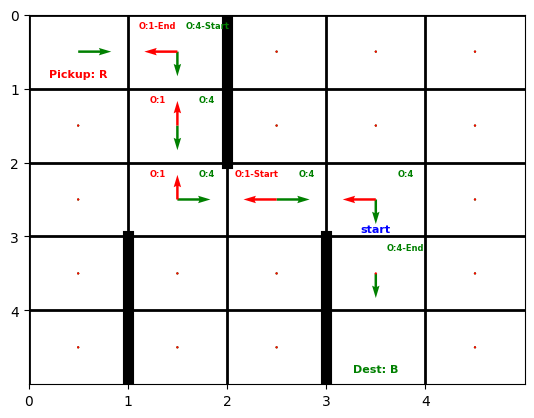

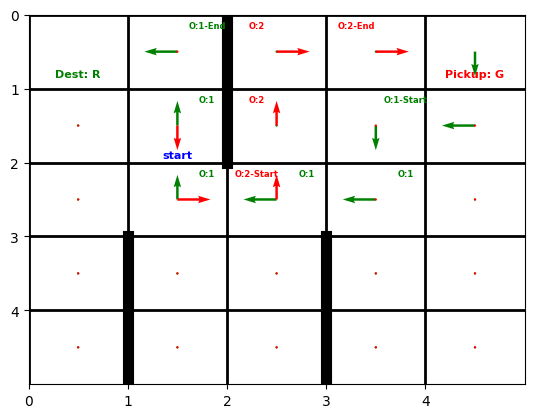

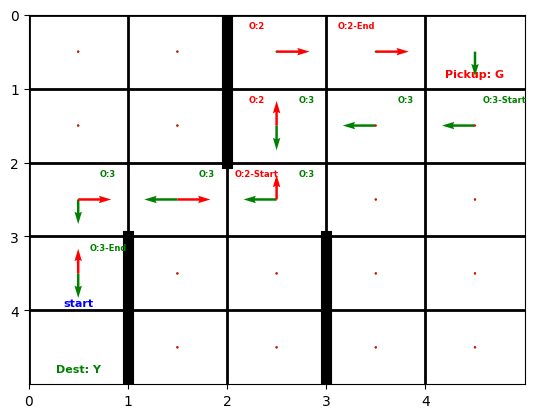

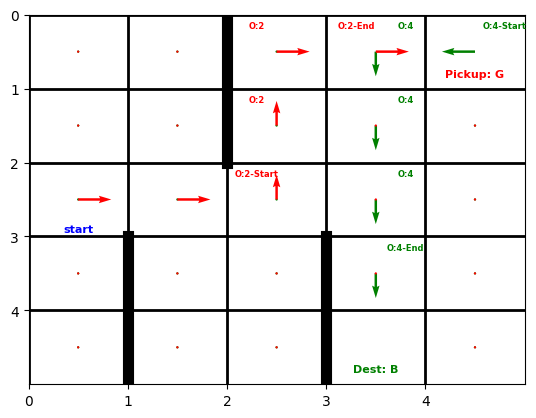

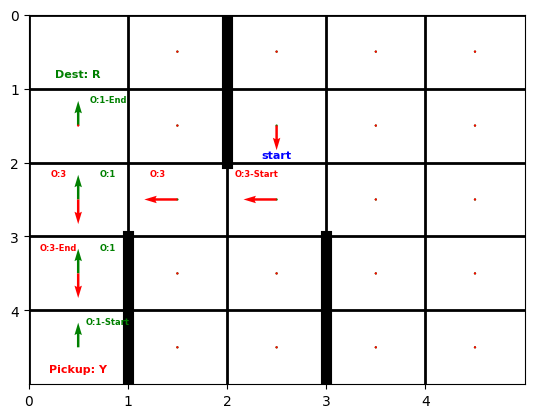

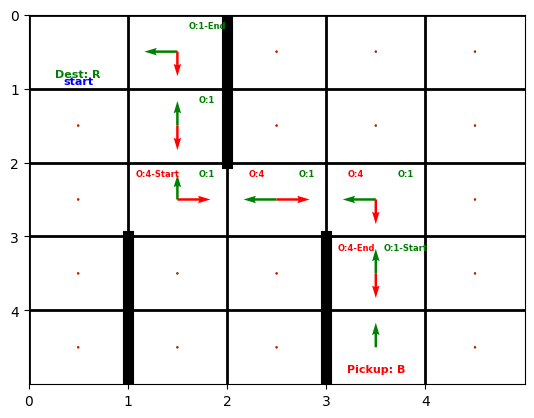

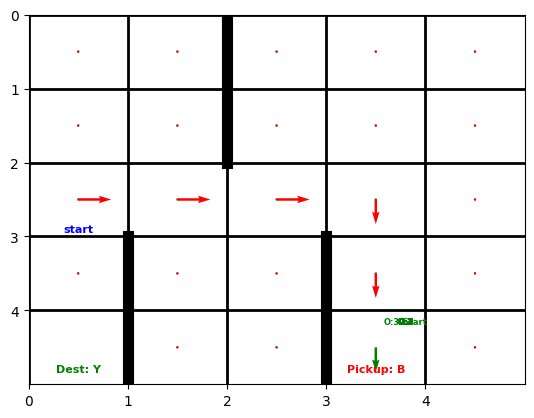

In [380]:
eval_policy(env, meanQ, OPT_LIST, offset=ctr)
ctr+=1

Final 100-step mean reward = 6.024


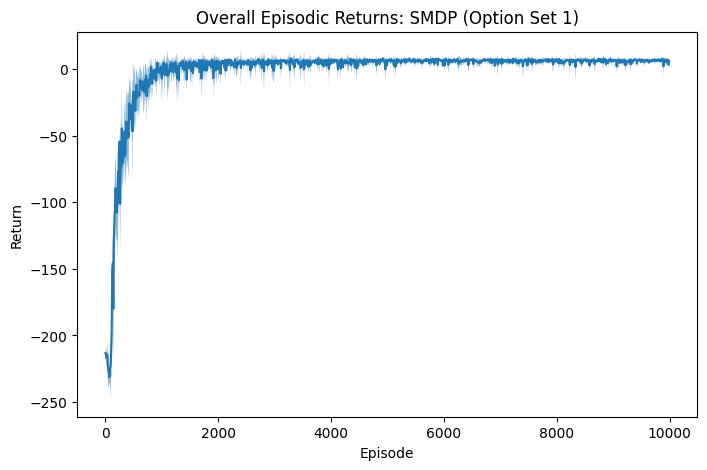

In [381]:
return_vs_episodes(all_ep_rewards, 'Overall Episodic Returns: SMDP (Option Set 1)', print_mean=True)

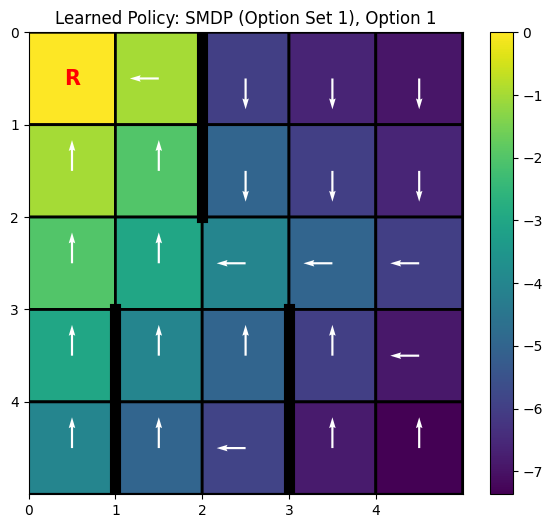

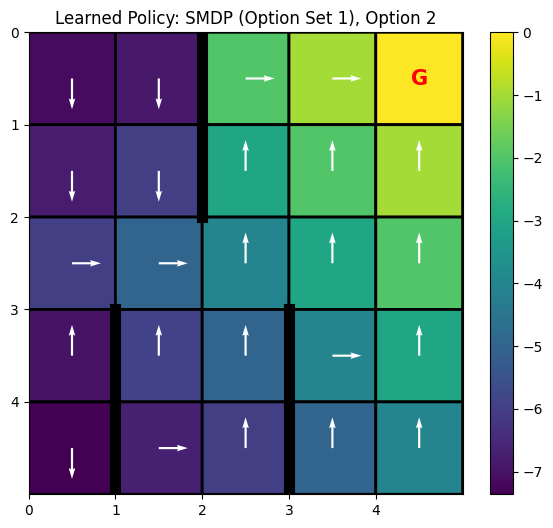

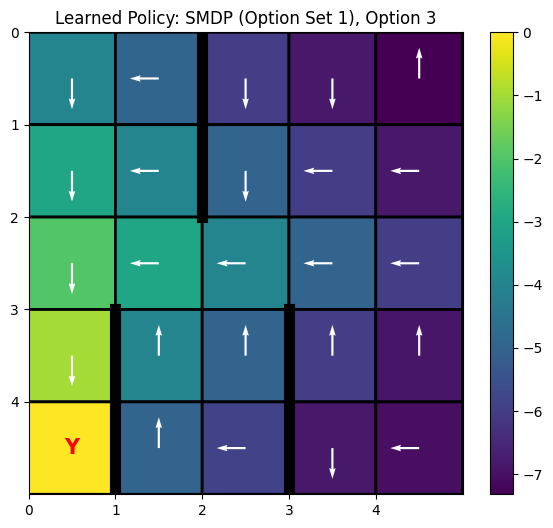

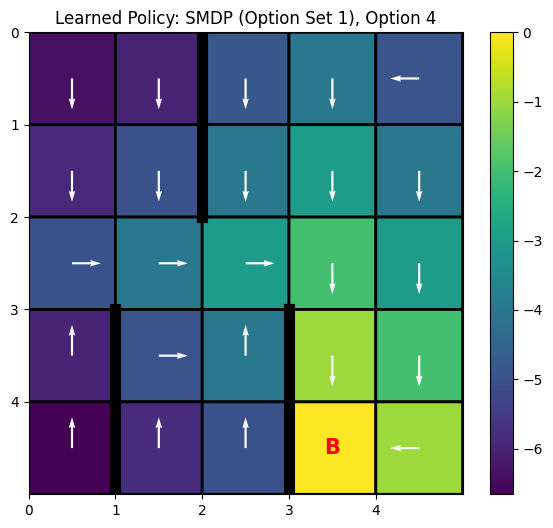

In [382]:
for index, option in enumerate(OPT_LIST): 
    plot_Q(option.Q, option.dest, f"Learned Policy: SMDP (Option Set 1), Option {index+1}")

## Intra-Option Q-Learning

### Algorithm

In [417]:
def intraopt(env: TaxiEnv, Q, OPT_LIST, episodes=100000, alpha=0.1, policy=softmax_policy, param=1.0, offset=0):
    option_rewards = [[] for _ in range(len(OPT_LIST))]
    episode_rewards = []
    
    for i in tqdm(range(episodes), leave=False):
        done, trunc = False, False
        episode_reward = 0
        state, _ = env.reset(i + episodes*offset)
        
        while not done and not trunc:
            action = policy(env.num_actions+len(OPT_LIST), Q, state, param)
            
            if action < env.num_actions:
                next_state, reward, done, trunc, _  = env.step(action)
                episode_reward+=reward
                Q[state, action] += alpha * (reward 
                                             + GAMMA*Q[next_state].max()
                                             - Q[state, action])
                
                for id, opt in enumerate(OPT_LIST, start=env.num_actions):
                    if env.decode_state(state) != opt.dest and opt.act(state) == action:
                        if env.decode_state(next_state)[:2] == opt.dest:
                            Q[state, id] += alpha * (reward 
                                                     + GAMMA*Q[next_state].max()
                                                     - Q[state, id])
                        else:
                            Q[state, id] += alpha * (reward
                                                     + GAMMA*Q[next_state, id]
                                                     - Q[state, id])
                
                state = next_state
                
            elif action < env.num_actions + len(OPT_LIST):
                i = action - env.num_actions
                opt = OPT_LIST[i]
                optdest = opt.dest
                if env.decode_state(state)[:2] == optdest:
                    continue    # option cannot be chosen from its termination state

                rewards = []
                optdone = False
                
                while not optdone and not trunc:
                    optact = opt.act(state)
                    next_state, reward, done, trunc, _ = env.step(optact)
                    episode_reward+=reward
                    rewards.append(reward)
                    opt.update(state, optact, reward, next_state)
                    
                    if env.decode_state(next_state)[:2] == optdest:
                        optdone = True

                    for id, op in enumerate(OPT_LIST, start=env.num_actions):
                        if env.decode_state(state) != opt.dest and op.act(state) == optact:
                            if env.decode_state(next_state)[:2] == op.dest:
                                Q[state, id] += alpha * (reward 
                                                        + GAMMA*Q[next_state].max()
                                                        - Q[state, id])
                            else:
                                Q[state, id] += alpha * (reward
                                                        + GAMMA*Q[next_state, id]
                                                        - Q[state, id])

                    state = next_state    
                option_rewards[i].append(sum(rewards)) 

            else:
                raise Exception("Undefined Action")
        episode_rewards.append(episode_reward)
    return episode_rewards, option_rewards
            

### Hyperparameter Selection

In [418]:
tau_list    = [0.75, 1.0, 1.25]
eps_list    = [0.05, 0.1, 0.2]
alpha_list  = [0.05, 0.1, 0.2, 0.3]

return_sums = {}

for alpha in tqdm(alpha_list, desc="Alpha Loop"):
    for tau in tqdm(tau_list, leave=False, desc="Tau loop"):
        Q.fill(0)
        for opt in OPT_LIST:
            opt.Q.fill(0)
        returns, _ = intraopt(env, Q, OPT_LIST,
                              episodes=10000, 
                              alpha=alpha, 
                              policy=softmax_policy, 
                              param=tau,
                              offset=ctr)
        ctr += 1
        return_sums[(alpha, softmax_policy, tau)] = sum(returns)

    for eps in tqdm(eps_list, leave=False, desc="Eps loop"):
        Q.fill(0)
        for opt in OPT_LIST:
            opt.Q.fill(0)
        returns, _ = intraopt(env, Q, OPT_LIST,
                              episodes=10000, 
                              alpha=alpha, 
                              policy=epsgreedy_policy, 
                              param=eps, 
                              offset=ctr)
        ctr += 1
        return_sums[(alpha, epsgreedy_policy, eps)] = sum(returns)

best_conf = max(return_sums, key=lambda x: return_sums[x])
print(f"Best configuration: {best_conf[0]}, {'softmax' if best_conf[1] == softmax_policy else 'epsilon-greedy'}, {best_conf[2]}")

Alpha Loop:   0%|          | 0/4 [00:00<?, ?it/s]




































































































































































































































































































































































































































































































Alpha Loop:  25%|██▌       | 1/4 [00:49<02:29, 49.98s/it]








































































































































































































































































































































































Alpha Loop:  50%|█████     | 2/4 [01:26<01:24, 4

Best configuration: 0.3, softmax, 0.75


### Evaluation

In [419]:
all_ep_rewards = []
all_op_rewards = [[] for _ in range(len(OPT_LIST))]
meanQ = np.zeros(Q.shape)
meanoptQ = [np.zeros(opt.Q.shape) for opt in OPT_LIST]

num_iter = 5

for _ in range(num_iter):
    Q.fill(0)
    for opt in OPT_LIST:
        opt.Q.fill(0)
    episode_rewards, option_rewards = intraopt(env, Q, OPT_LIST, 10000, *best_conf, ctr)
    ctr += 1   
    meanQ += Q
    for i, opt in enumerate(OPT_LIST):
        meanoptQ[i] += opt.Q
    all_ep_rewards.append(episode_rewards)
    for i, rewards in enumerate(option_rewards):
        all_op_rewards[i].append(rewards)

meanQ /= 5
for i, opt in enumerate(OPT_LIST):
    meanoptQ[i] /= 5
    opt.Q = meanoptQ[i]

  0%|          | 0/10000 [00:00<?, ?it/s]

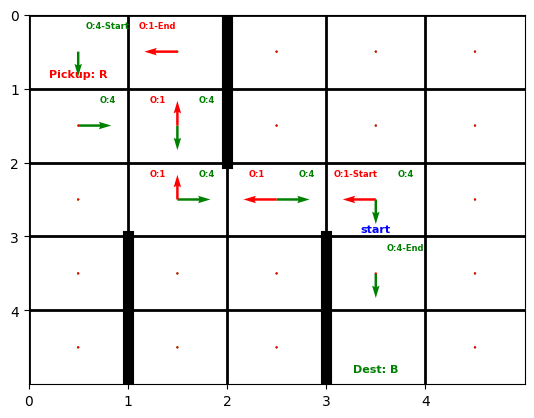

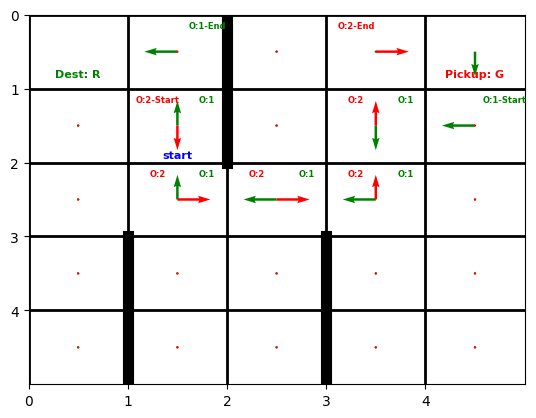

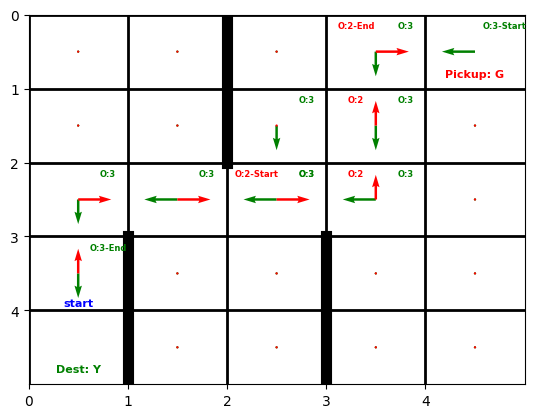

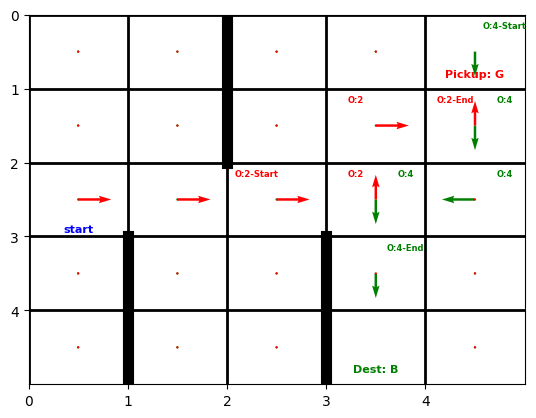

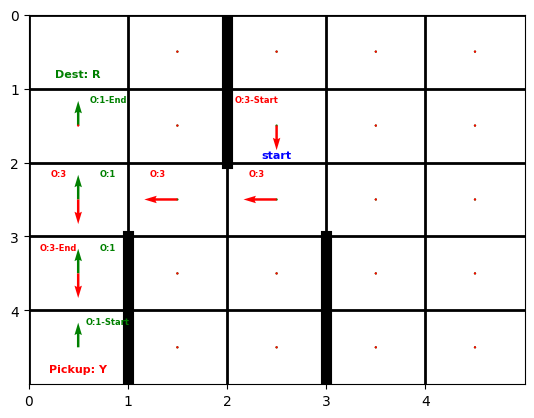

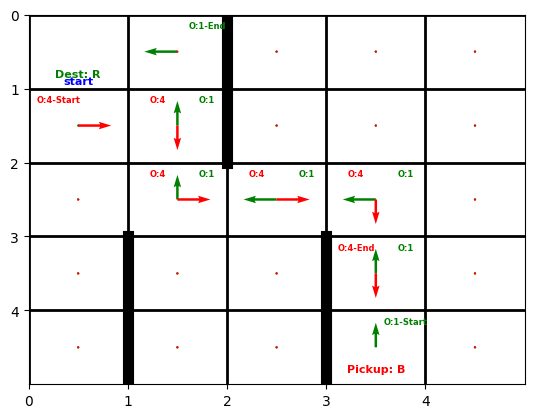

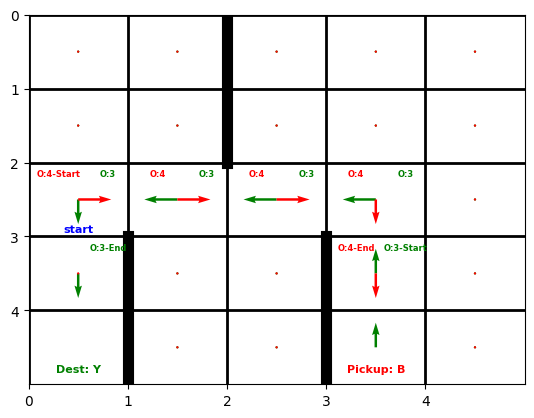

In [420]:
eval_policy(env, meanQ, OPT_LIST, offset=ctr)
ctr+=1

Final 100-step mean reward = 7.388


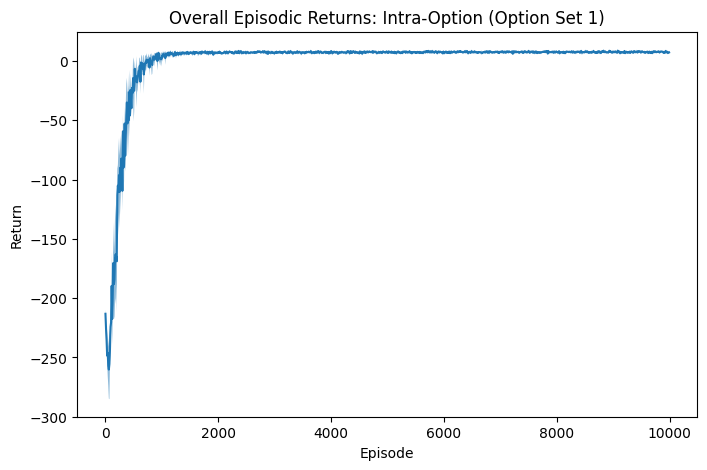

In [421]:
return_vs_episodes(all_ep_rewards, 'Overall Episodic Returns: Intra-Option (Option Set 1)', print_mean=True)

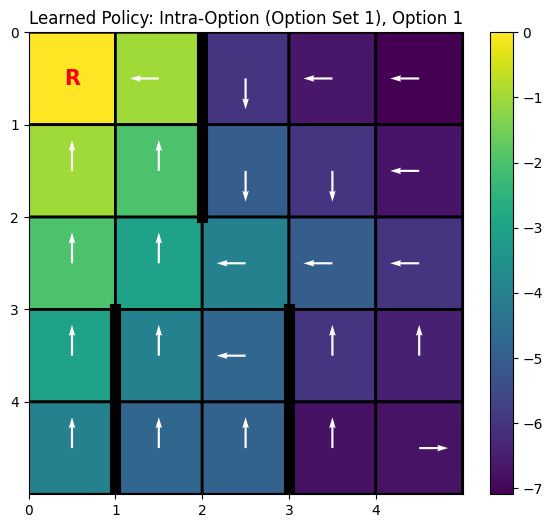

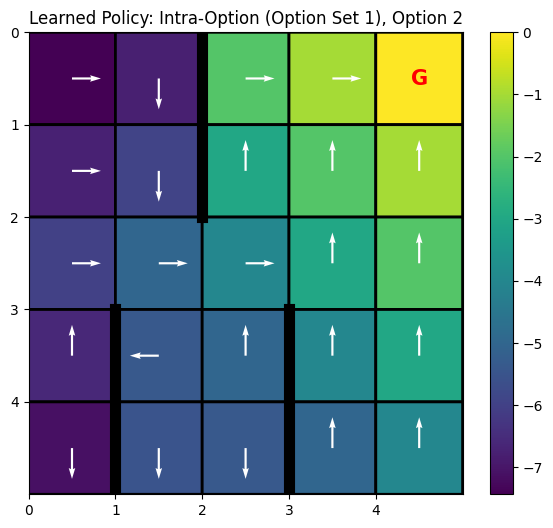

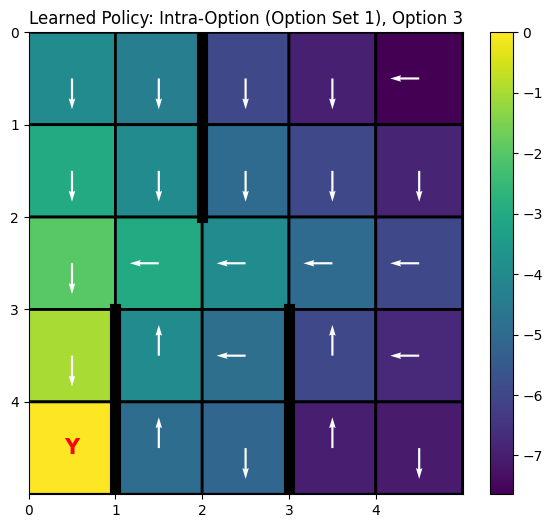

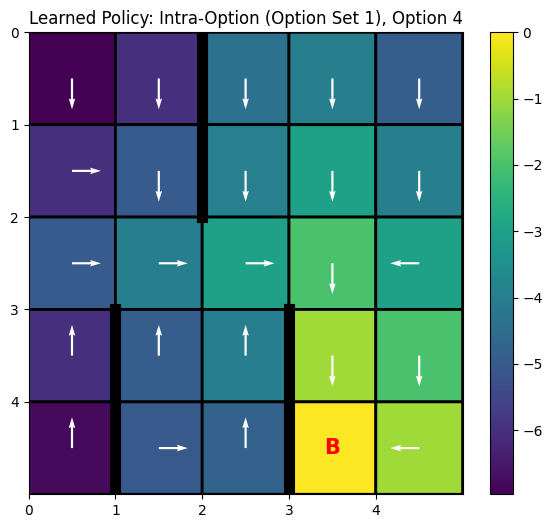

In [422]:
for index, option in enumerate(OPT_LIST): 
    plot_Q(option.Q, option.dest, f"Learned Policy: Intra-Option (Option Set 1), Option {index+1}")

## Alternate Options

Here, we will use the following two options:
* Navigate and Pickup: Can be called only when passenger is not in the taxi. Navigates to the pickup point and picks up the passenger
* Navigate and Dropoff: Can be called only when passenger is in the taxi. Navigates to the destination point and drops off the passenger

### Option Instantiation

In [389]:
ALT_LIST = [NavOption(env, dest, policy, start, end, decay, alpha) for dest in [(2, 0), (2, 3)]]

In [390]:
Q = np.empty((env.num_states, env.num_actions+len(ALT_LIST)), dtype=float)

### SMDP Q-Learning 

In [391]:
tau_list    = [0.75, 1.0, 1.25]
eps_list    = [0.05, 0.1, 0.2]
alpha_list  = [0.05, 0.1, 0.2, 0.3]

return_sums = {}

for alpha in tqdm(alpha_list, desc="Alpha Loop"):
    for tau in tqdm(tau_list, leave=False, desc="Tau loop"):
        Q.fill(0)
        for opt in ALT_LIST:
            opt.Q.fill(0)
        returns, _ = smdp(env, Q, ALT_LIST,
                              episodes=10000, 
                              alpha=alpha, 
                              policy=softmax_policy, 
                              param=tau,
                              offset=ctr)
        ctr += 1
        return_sums[(alpha, softmax_policy, tau)] = sum(returns)

    for eps in tqdm(eps_list, leave=False, desc="Eps loop"):
        Q.fill(0)
        for opt in ALT_LIST:
            opt.Q.fill(0)
        returns, _ = smdp(env, Q, ALT_LIST,
                              episodes=10000, 
                              alpha=alpha, 
                              policy=epsgreedy_policy, 
                              param=eps, 
                              offset=ctr)
        ctr += 1
        return_sums[(alpha, epsgreedy_policy, eps)] = sum(returns)

best_conf = max(return_sums, key=lambda x: return_sums[x])
print(f"Best configuration: {best_conf[0]}, {'softmax' if best_conf[1] == softmax_policy else 'epsilon-greedy'}, {best_conf[2]}")

Alpha Loop:   0%|          | 0/4 [00:00<?, ?it/s]
























































































































































































































































































































































































































































































































































































































































































































































































































































































































































































Best configuration: 0.3, softmax, 1.0


In [392]:
all_ep_rewards = []
all_op_rewards = [[] for _ in range(len(ALT_LIST))]
meanQ = np.zeros(Q.shape)
meanoptQ = [np.zeros(opt.Q.shape) for opt in ALT_LIST]

num_iter = 5

for _ in range(num_iter):
    Q.fill(0)
    for opt in ALT_LIST:
        opt.Q.fill(0)
    episode_rewards, option_rewards = smdp(env, Q, ALT_LIST, 10000, *best_conf, offset=ctr)
    ctr += 1   
    meanQ += Q
    for i, opt in enumerate(ALT_LIST):
        meanoptQ[i] += opt.Q
    all_ep_rewards.append(episode_rewards)
    for i, rewards in enumerate(option_rewards):
        all_op_rewards[i].append(rewards)

meanQ /= 5
for i, opt in enumerate(ALT_LIST):
    meanoptQ[i] /= 5
    opt.Q = meanoptQ[i]

  0%|          | 0/10000 [00:00<?, ?it/s]

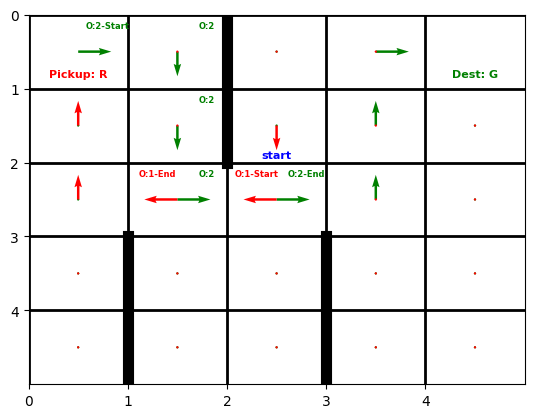

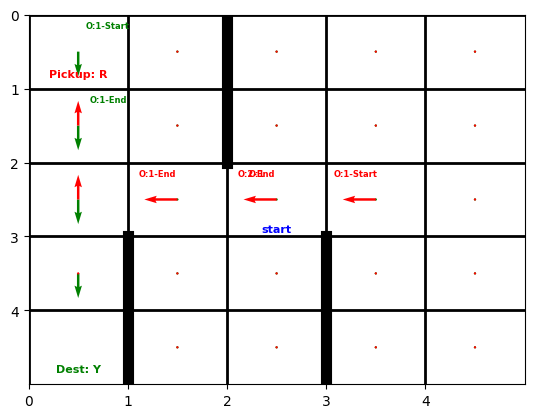

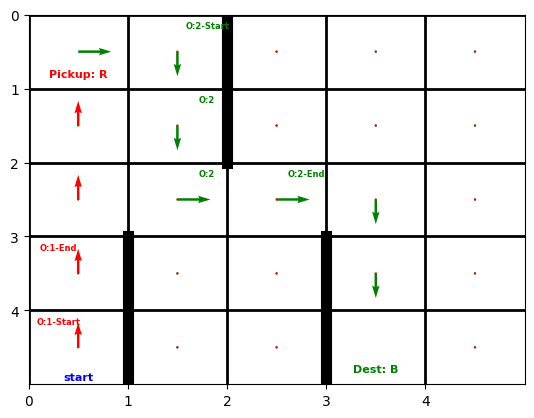

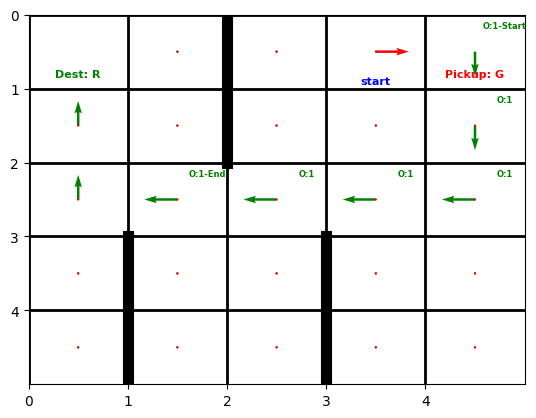

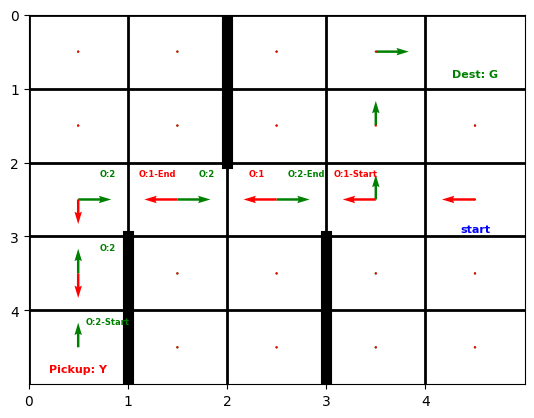

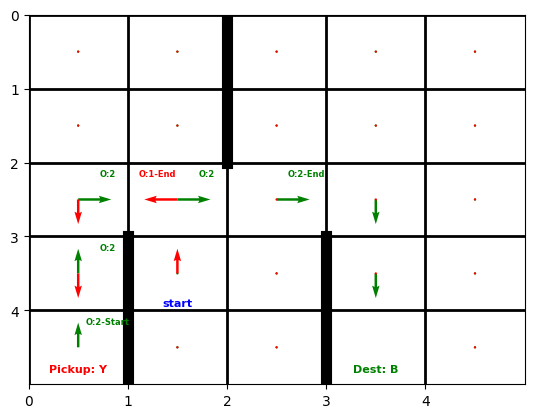

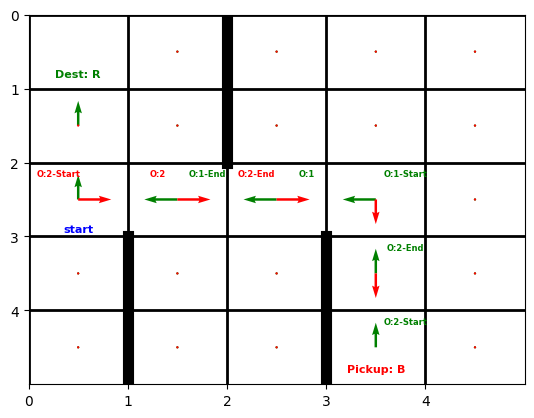

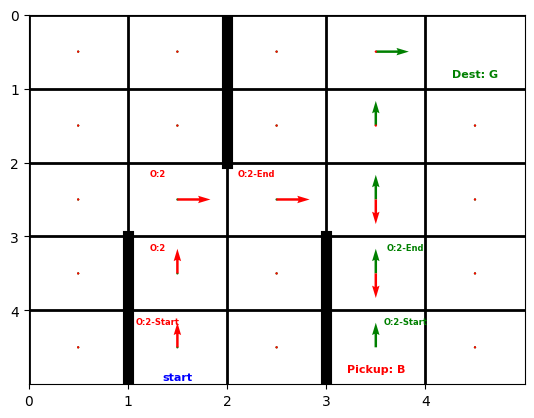

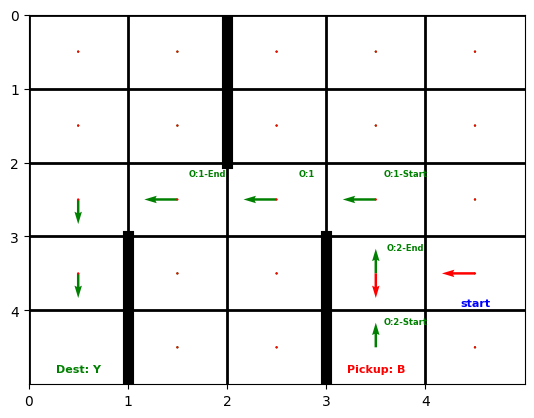

In [393]:
eval_policy(env, meanQ, ALT_LIST, offset=ctr)
ctr+=1

Final 100-step mean reward = 7.702


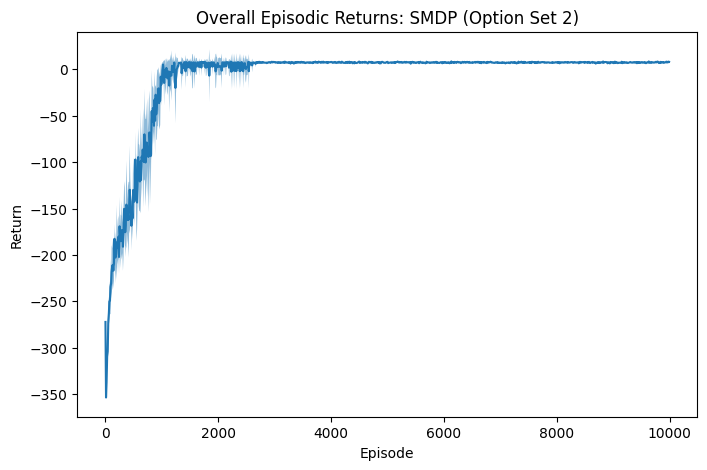

In [394]:
return_vs_episodes(all_ep_rewards, 'Overall Episodic Returns: SMDP (Option Set 2)', print_mean=True)

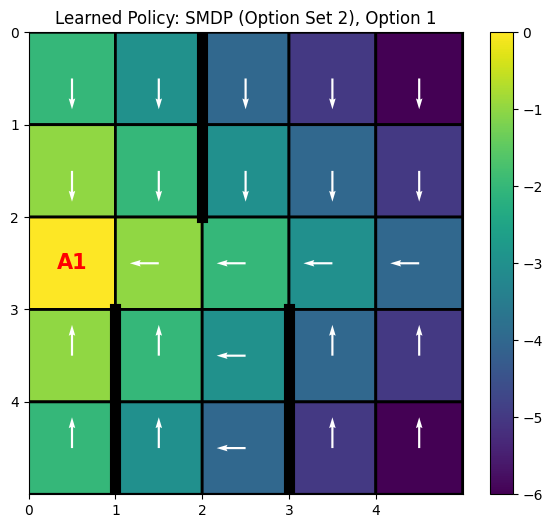

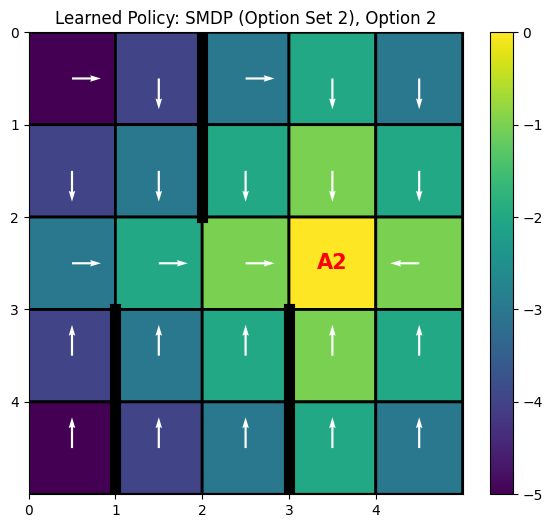

In [395]:
for index, option in enumerate(ALT_LIST): 
    plot_Q(option.Q, option.dest, f"Learned Policy: SMDP (Option Set 2), Option {index+1}")

### Intra-Option Q-Learning

In [396]:
tau_list    = [0.75, 1.0, 1.25]
eps_list    = [0.05, 0.1, 0.2]
alpha_list  = [0.05, 0.1, 0.2, 0.3]

return_sums = {}

for alpha in tqdm(alpha_list, desc="Alpha Loop"):
    for tau in tqdm(tau_list, leave=False, desc="Tau loop"):
        Q.fill(0)
        for opt in ALT_LIST:
            opt.Q.fill(0)
        returns, _ = intraopt(env, Q, ALT_LIST, 
                                  episodes=10000, 
                                  alpha=alpha, 
                                  policy=softmax_policy, 
                                  param=tau,
                                  offset=ctr)
        ctr += 1
        return_sums[(alpha, softmax_policy, tau)] = sum(returns)

    for eps in tqdm(eps_list, leave=False, desc="Eps loop"):
        Q.fill(0)
        for opt in ALT_LIST:
            opt.Q.fill(0)
        returns, _ = intraopt(env, Q, ALT_LIST,
                                  episodes=10000, 
                                  alpha=alpha, 
                                  policy=epsgreedy_policy, 
                                  param=eps, 
                                  offset=ctr)
        ctr += 1
        return_sums[(alpha, epsgreedy_policy, eps)] = sum(returns)

best_conf = max(return_sums, key=lambda x: return_sums[x])
print(f"Best configuration: {best_conf[0]}, {'softmax' if best_conf[1] == softmax_policy else 'epsilon-greedy'}, {best_conf[2]}")

Alpha Loop:   0%|          | 0/4 [00:00<?, ?it/s]


































































































































































































































































































































































































Alpha Loop:  25%|██▌       | 1/4 [00:39<01:58, 39.56s/it]


























































































































































































































































































Alpha Loop:  50%|█████     | 2/4 [01:07<01:05, 32.80s/it]








































































































































































Best configuration: 0.3, softmax, 0.75


In [397]:
all_ep_rewards = []
all_op_rewards = [[] for _ in range(len(ALT_LIST))]
meanQ = np.zeros(Q.shape)
meanoptQ = [np.zeros(opt.Q.shape) for opt in ALT_LIST]

num_iter = 5

for _ in range(num_iter):
    Q.fill(0)
    for opt in ALT_LIST:
        opt.Q.fill(0)
    episode_rewards, option_rewards = intraopt(env, Q, ALT_LIST, 10000, *best_conf, ctr)
    ctr += 1   
    meanQ += Q
    for i, opt in enumerate(ALT_LIST):
        meanoptQ[i] += opt.Q
    all_ep_rewards.append(episode_rewards)
    for i, rewards in enumerate(option_rewards):
        all_op_rewards[i].append(rewards)

meanQ /= 5
for i, opt in enumerate(ALT_LIST):
    meanoptQ[i] /= 5
    opt.Q = meanoptQ[i]

Final 100-step mean reward = 7.906


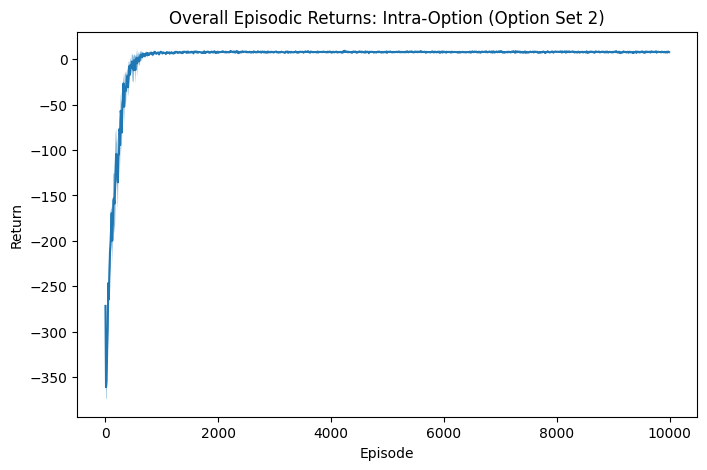

In [398]:
return_vs_episodes(all_ep_rewards, 'Overall Episodic Returns: Intra-Option (Option Set 2)', print_mean=True)

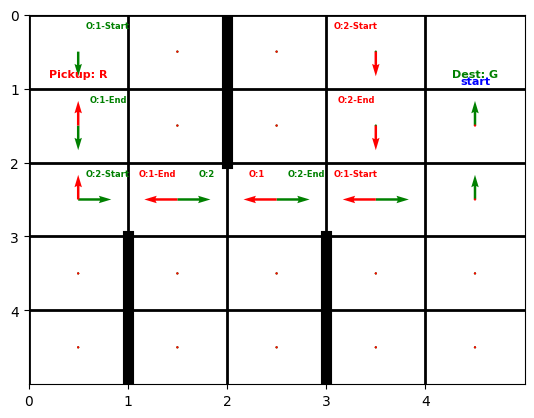

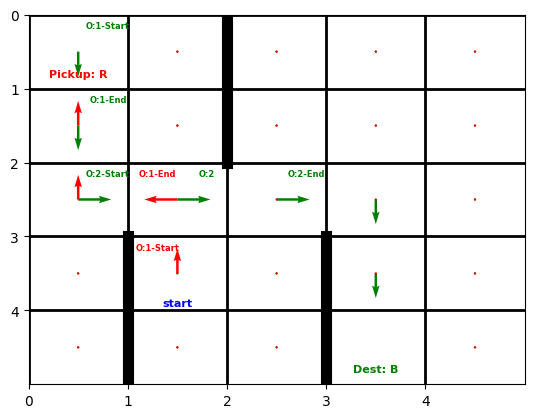

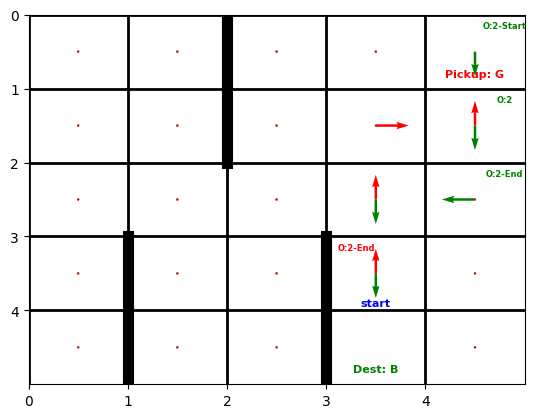

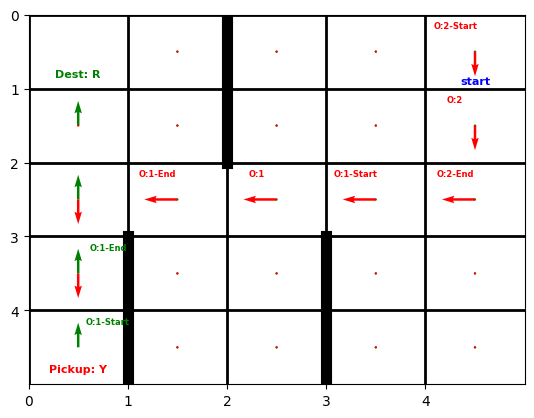

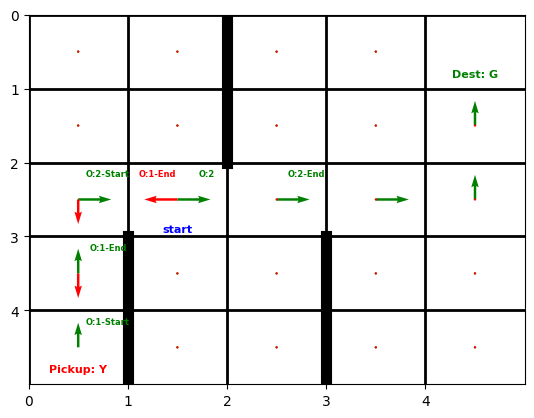

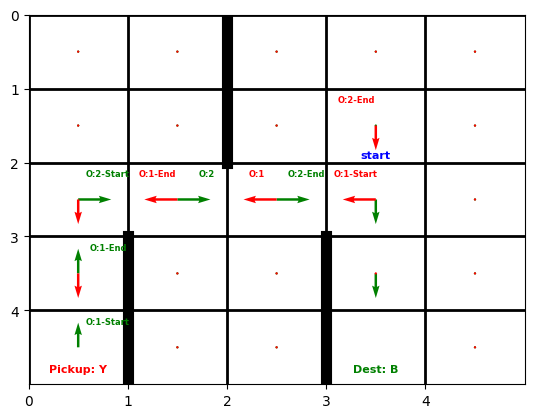

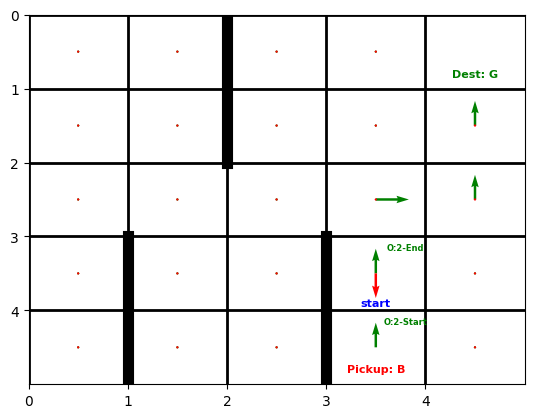

In [399]:
eval_policy(env, meanQ, ALT_LIST,offset=ctr)
ctr+=1

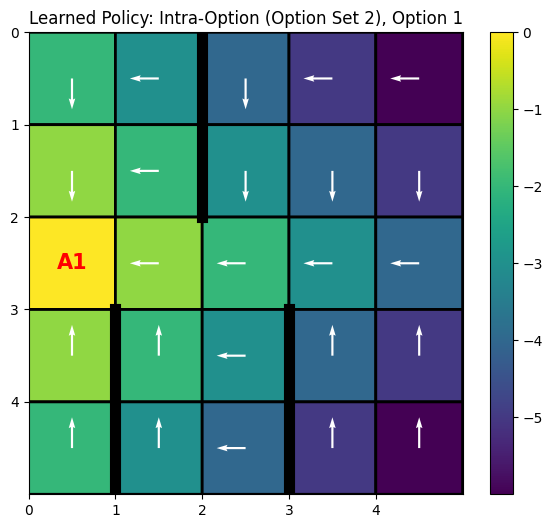

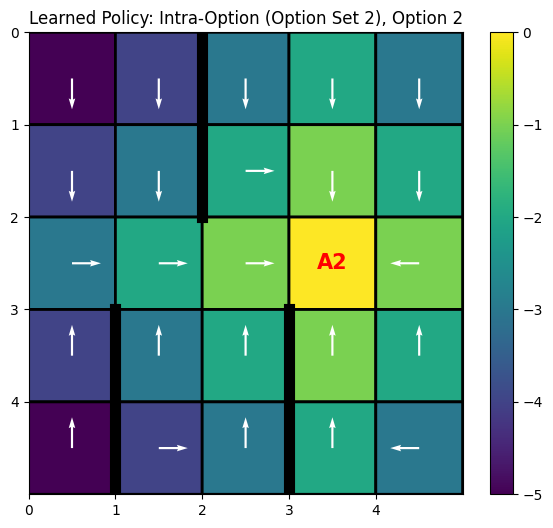

In [400]:
for index, option in enumerate(ALT_LIST): 
    plot_Q(option.Q, option.dest, f"Learned Policy: Intra-Option (Option Set 2), Option {index+1}")